# Instantiation of Julia environment

In [1]:
using Pkg
Pkg.activate("..") #Activate the project environment
Pkg.instantiate() #Install the required packages    
# Load the required packages
using ModelingToolkit, DifferentialEquations, Plots

  Activating project at `c:\Users\Marcu\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression`
  0 dependencies successfully precompiled in 47 seconds. 517 already precompiled.


# Lorenz Attractor example
The Lorenz Attractor is a system of ordinary differential equations that exhibits chaotic behavior. 
It is used to demonstrate the concept of chaos in dynamical systems, and is often included as a benchmark for numerical methods in scientific computing. The equations are defined as follows:

In [2]:

## LORENZ ATTRACTOR
@parameters σ ρ β
@independent_variables t
@variables x(t) y(t) z(t)
D = Differential(t)

eqs = [D(x) ~ σ * (y - x),
    D(y) ~ x * (ρ - z) - y,
    D(z) ~ x * y - β * z]

# Define the system
@named sys = ODESystem(eqs, t)
sys = complete(sys)

Model sys:
Equations (3):
  3 standard: see equations(sys)
Unknowns (3): see unknowns(sys)
  x(t)
  y(t)
  z(t)
Parameters (3): see parameters(sys)
  ρ
  β
  σ

## Simulation Parameters

The solution of the Lorenz system is sensitive to initial conditions, and small changes can lead to vastly different outcomes. The parameters used in the simulation are:
$$
\sigma = 10, \quad \rho = 28, \quad \beta = \frac{8}{3}
$$
with the initial conditions:
$$
x(0) = 1, \quad y(0) = 1, \quad z(0) = 1
$$
And the time span for the simulation is:
$$
t = [0, 100]
$$
Sampled at 0.01 intervals.

In [3]:
# Define the initial conditions and parameters
u0 = [
    x => 1.0,
    y => 0.0,
    z => 0.0]

p = Dict([σ => 10.0,
    ρ => 28.0,
    β => 8/3])

# Define the time span
timesteps = collect(0.0:0.01:10.0)

# Simulate the system
prob = ODEProblem(sys, u0,(timesteps[1], timesteps[end]) ,p, saveat = timesteps)
sol = solve(prob)

retcode: Success
Interpolation: 1st order linear
t: 1001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.06
  0.07
  0.08
  0.09
  ⋮
  9.92
  9.93
  9.94
  9.95
  9.96
  9.97
  9.98
  9.99
 10.0
u: 1001-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [0.9179244486277375, 0.26633998839581724, 0.001263896161024725]
 [0.8679193806275332, 0.5117405221648618, 0.004655448984590432]
 [0.8453600810426154, 0.7446542578853702, 0.009835866378811885]
 [0.8468056451055698, 0.9723322686163748, 0.016734529881783027]
 [0.8697858478632923, 1.2011328308689113, 0.02548624360802408]
 [0.9126414552179822, 1.4367663939445778, 0.036401157668566025]
 [0.9743847413599666, 1.6845201726739139, 0.0499584260367446]
 [1.0546231178436563, 1.9494049510744307, 0.06681568581595387]
 [1.1534564425090579, 2.236343236002593, 0.08784004081161305]
 ⋮
 [-6.5471439121022525, -4.737157124688209, 27.183649547015616]
 [-6.375263940266686, -4.75778129601343, 26.77106062867018]
 [-6.222969968077115, -4.801

# Physics Informed Regression (PIR)
We proceed to illustrate the use of Physics Informed Regression (PIR) to solve the inverse problem of the Lorenz system. The goal is to recover the parameters $\sigma$, $\rho$, and $\beta$ from the observed data. The PIR approach incorporates the governing equations of the system into the regression model, by rewriting the equations as linear system in terms of the parameters. The system and right hand side are given by:

In [4]:
# Setup model for regression
using Latexify
using LaTeXStrings
using PhysicsInformedRegression

du_approx = PhysicsInformedRegression.finite_diff(sol.u, sol.t) #approximated derivatives
A,b = PhysicsInformedRegression.setup_linear_system(sys)
A_sym = latexify(A)
b_sym = latexify(b)
display(L"A = %$A_sym")
display(L"b = %$b_sym")

L"$A = \begin{equation}
\left[
\begin{array}{ccc}
0.0 & 0.0 &  - x\left( t \right) + y\left( t \right) \\
x\left( t \right) & 0.0 & 0.0 \\
0.0 &  - z\left( t \right) & 0.0 \\
\end{array}
\right]
\end{equation}
$"

L"$b = \begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d} x\left( t \right)}{\mathrm{d}t} \\
y\left( t \right) + \frac{\mathrm{d} y\left( t \right)}{\mathrm{d}t} + x\left( t \right) z\left( t \right) \\
\frac{\mathrm{d} z\left( t \right)}{\mathrm{d}t} - x\left( t \right) y\left( t \right) \\
\end{array}
\right]
\end{equation}
$"

Consequently, the Lorenz system can be expressed in matrix form as:
$$
\begin{align*}
A \begin{bmatrix}
    \sigma \\
    \rho \\
    \beta
    \end{bmatrix} = b
\end{align*}
$$
where $A$ is the matrix of parameters and $b$ is the right-hand side vector. The goal is to find the parameters that minimize the residuals of the system, which can be formulated as a least squares problem. 
$$
\begin{align*}
\sigma^*, \rho^*, \beta^* &=
\min_{\sigma, \rho, \beta} \left\| A \begin{bmatrix}
    \sigma \\
    \rho \\
    \beta
    \end{bmatrix} - b \right\|^2\\
    &= (A^T A)^{-1} A^T b
\end{align*}
$$
For the observed data, $A$ and $b$ are constructed and concatenated for all observations. The results of the yields the following estimates of the parameters $\sigma^*, \rho^*, \beta^*$:

In [5]:
# Estimate the parameters
paramsest = PhysicsInformedRegression.physics_informed_regression(sys, sol.u, du_approx, A, b)

#compare the estimated parameters to the true parameters
parameterdict = Dict(p)
for (i, param) in enumerate(parameters(sys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
end

Parameter ρ = 28.0 estimated as 28.006521633973943
Parameter β = 2.6666666666666665 estimated as 2.6674891329702284
Parameter σ = 10.0 estimated as 9.970285666727058


## Illustration of the recovered system
The simulation is run with the recovered parameters, and the results are compared to the original system. The solution is plotted to visualize the accuracy of the recovery. The recovered parameters are expected to be close to the original parameters, and the solution should exhibit similar behavior to the original system.

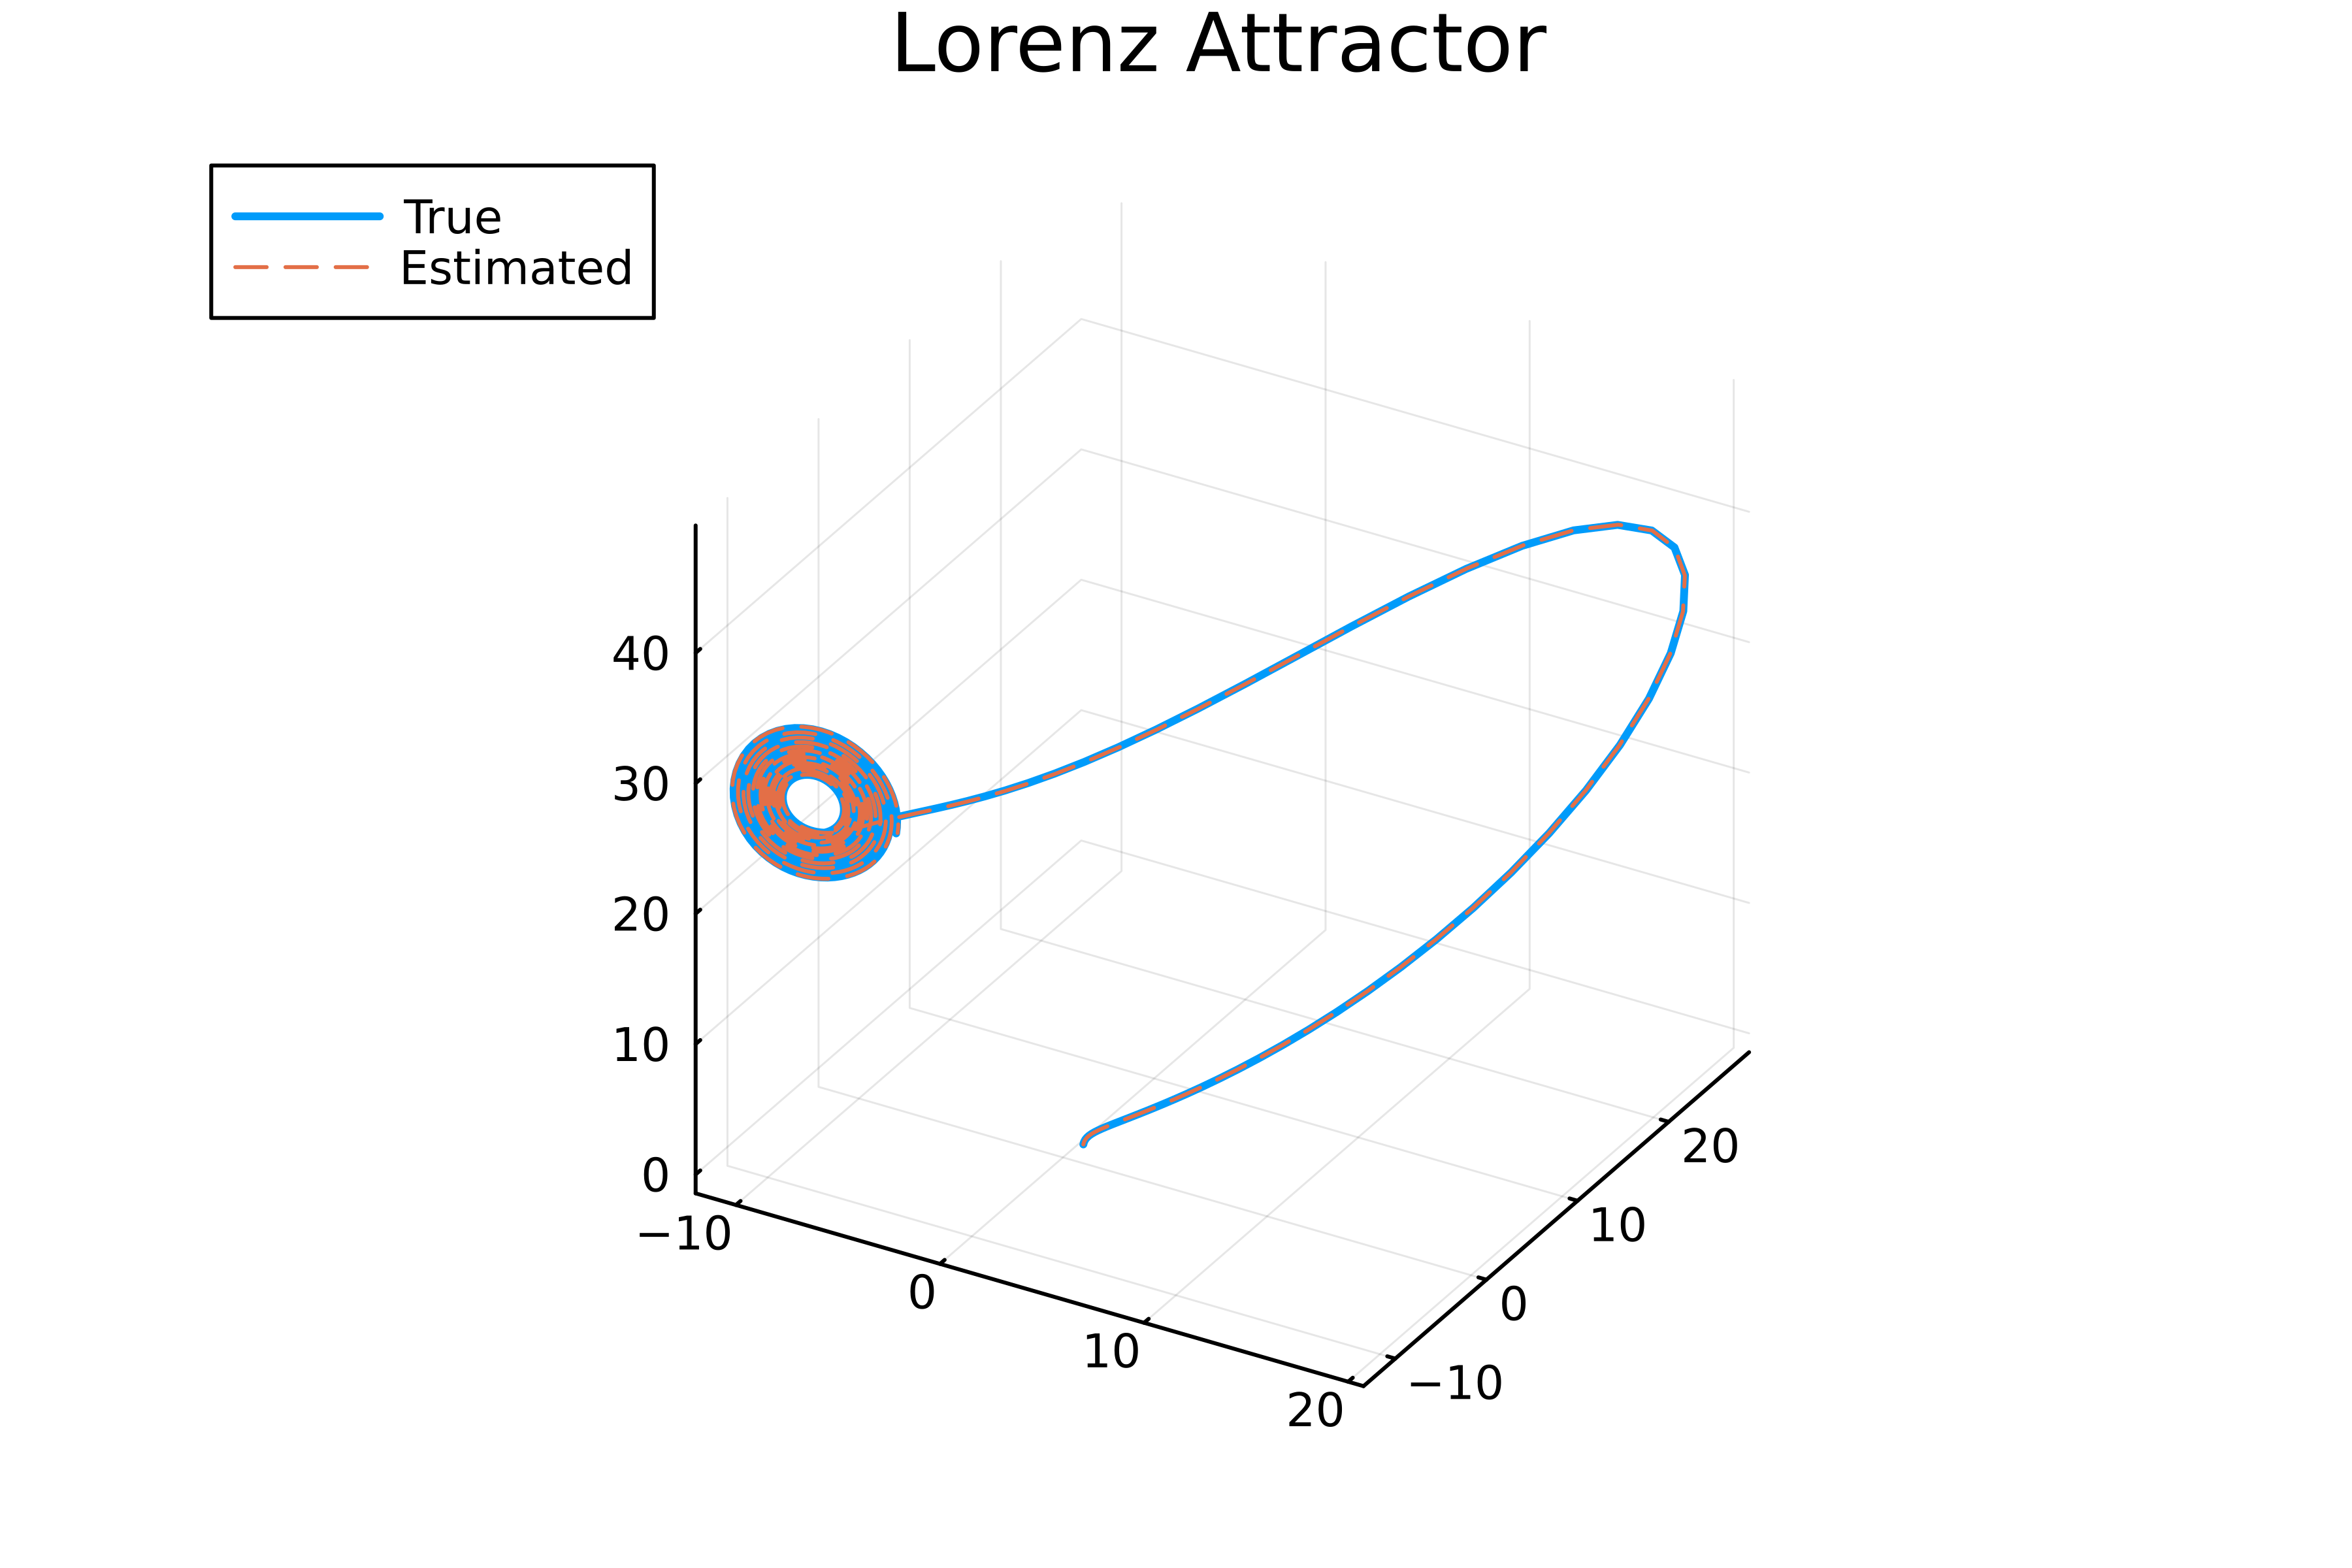

In [6]:
sol_est = solve(ODEProblem(sys, u0,(timesteps[1], timesteps[end]) ,paramsest), Tsit5(), saveat = timesteps)
p1 = plot(sol,label = "True", title = "Lorenz Attractor", lw = 2, dpi = 600, idxs = (1,2,3))
plot!(p1, sol_est, label = "Estimated", lw = 1, ls = :dash, dpi = 600, idxs = (1,2,3))
#savefig("../plots/Lorenz.png")
display(p1)

# Evaluating the results
The regression is run once again for different numbers of collocation points, and the results are compared to the original parameters. The goal is to see how the number of collocation points affects the accuracy of the recovery. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves. 


In [7]:
using Random
Random.seed!(1234) # Set seed for reproducibility
include("../utils/julia_utils.jl")
export create_table, noise_v_collocation_points

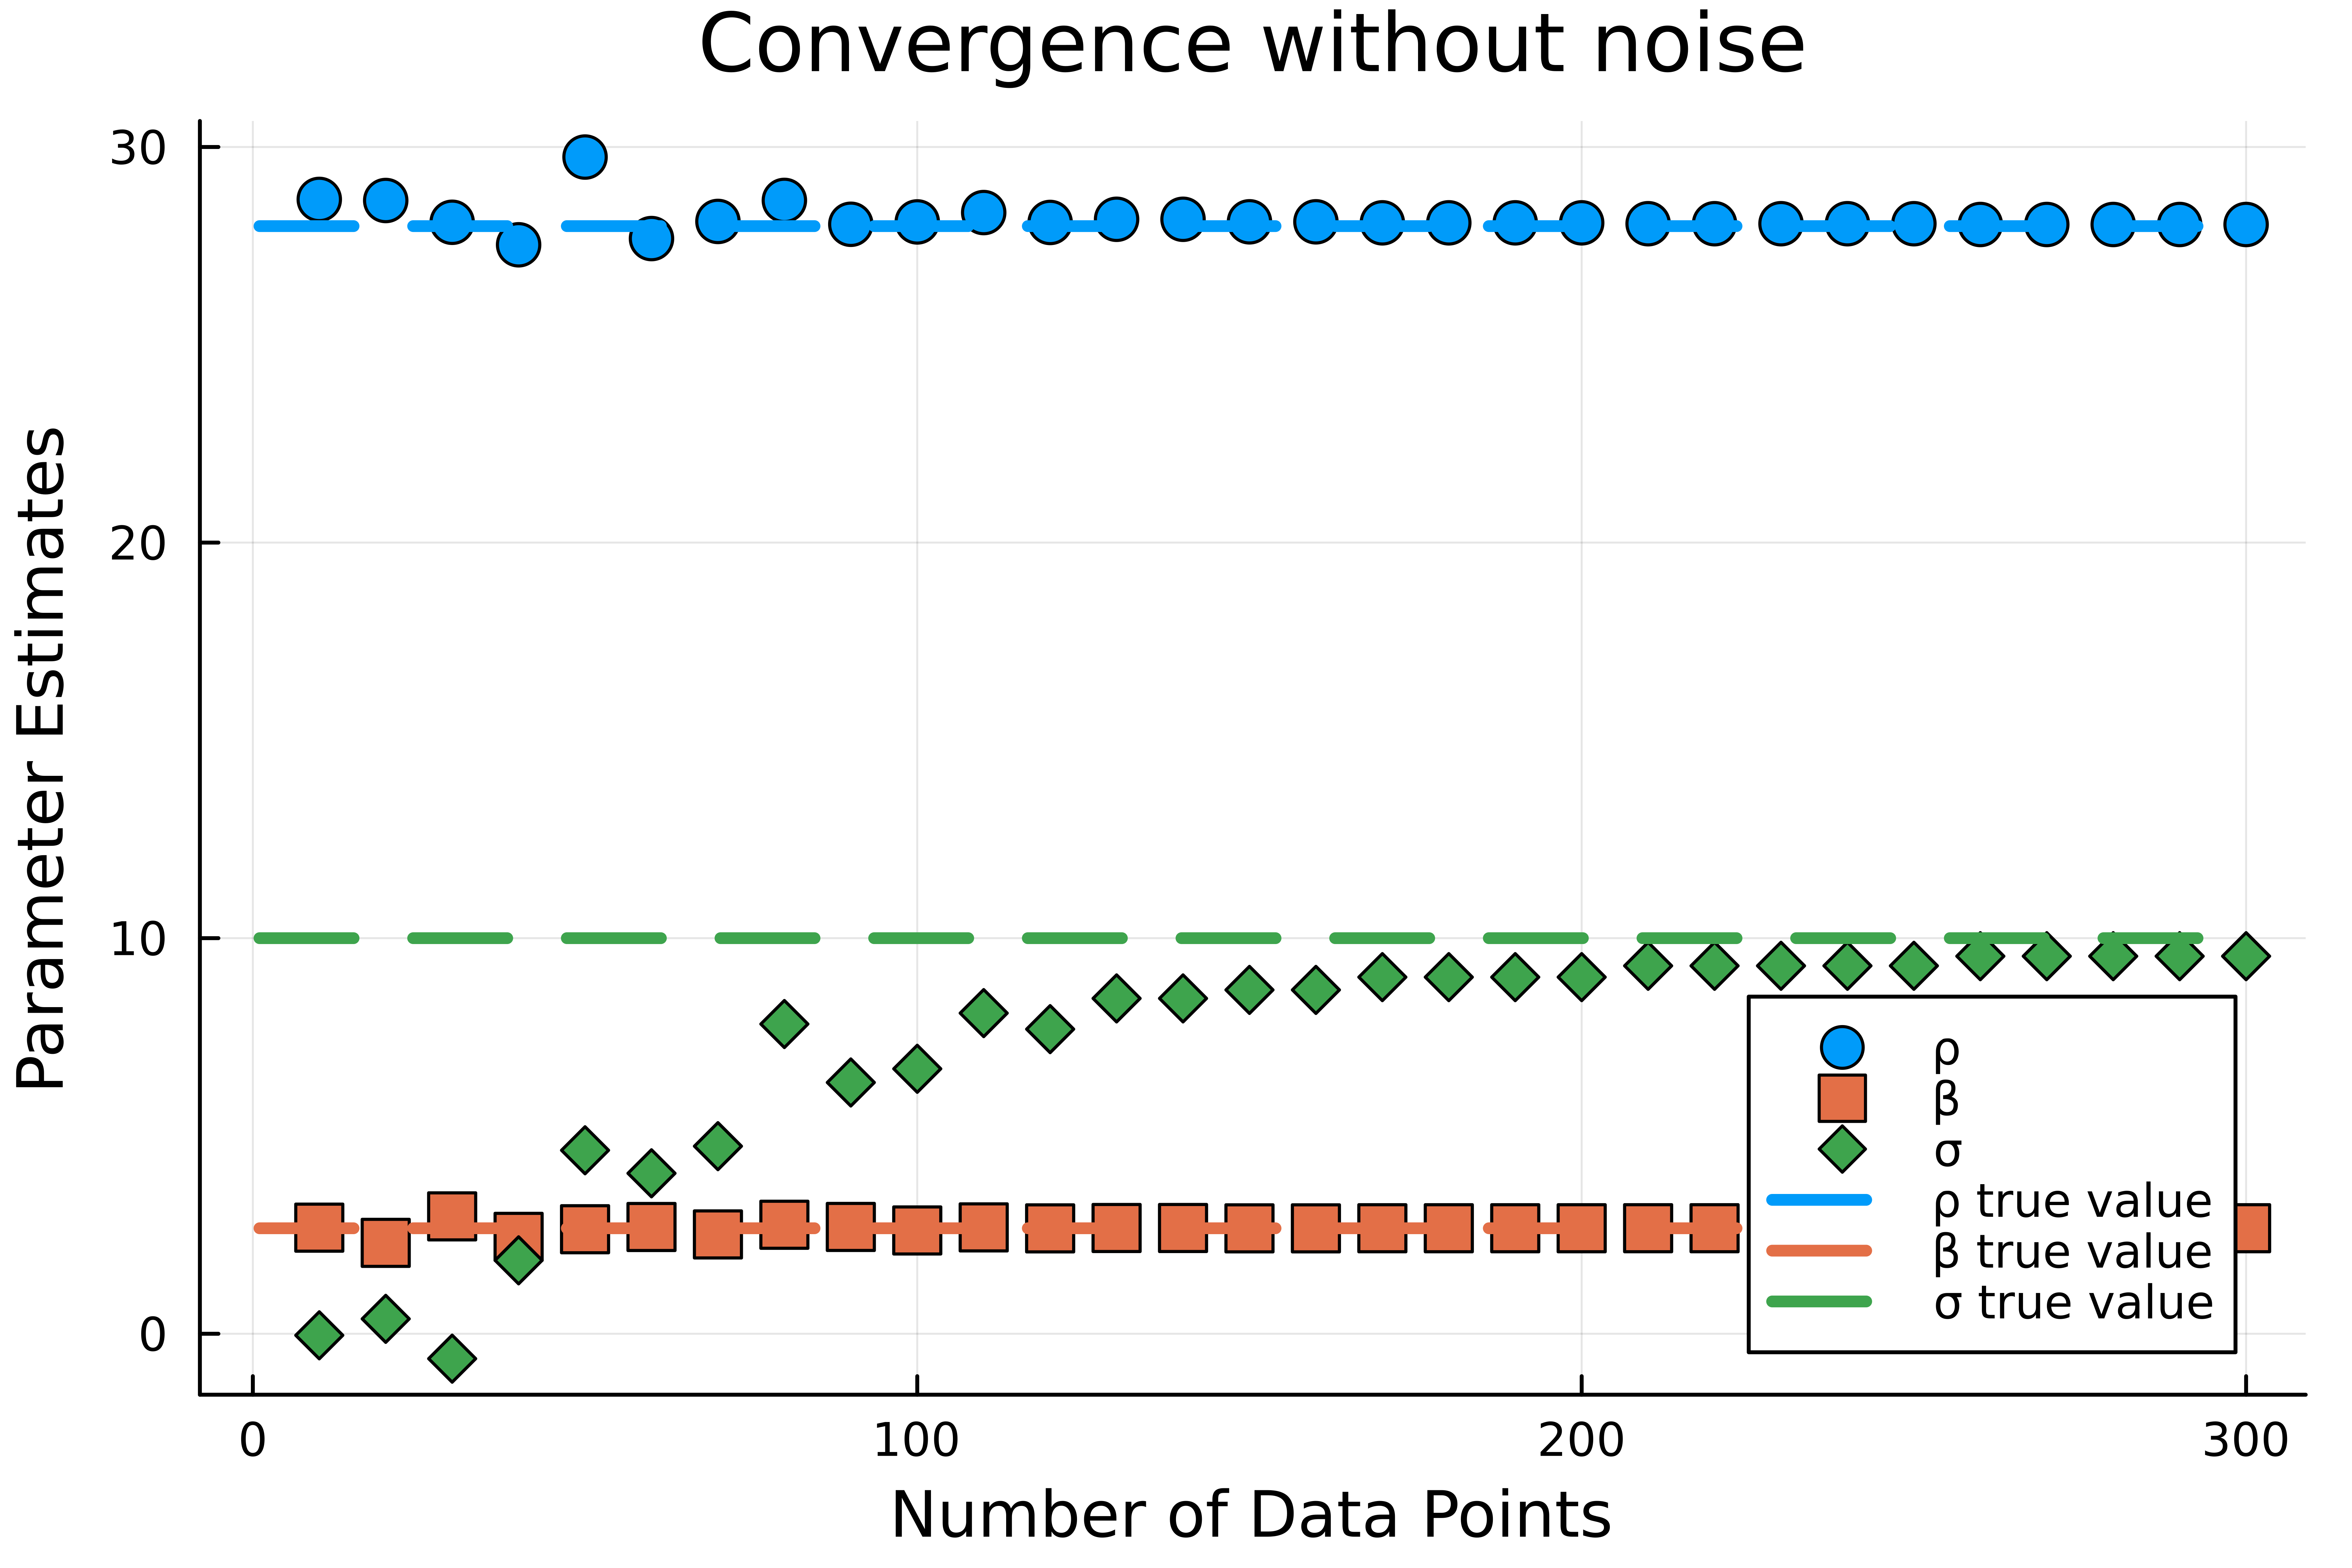

In [22]:
noise_vals = [0.0]
n_data_points = collect(10:10:300)
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

#parameter convergence without noise
marker_shapes = [:circle, :square, :diamond, :utriangle]
p1 = plot()
parameter_names = [string(param) for param in parameters(sys)]
x_values = collect(first.(keys(parameter_estimates)))
parameter_values = hcat([collect(values(parameter_estimates[n_data_points, 0.0])) for n_data_points in x_values]...)
scatter!(p1, x_values, parameter_values', label = hcat(parameter_names...), xlabel = "Number of Data Points", ylabel = "Parameter Estimates",
     title = "Convergence without noise", lw = 2, dpi = 1200, markershape = hcat(marker_shapes...), markersize = 6)
#plot horizontal lines for true parameter values
for (i, param) in enumerate(parameters(sys))
    plot!(p1, [1, maximum(n_data_points)], repeat([p[param]], 2), label = "$(param) true value", ls = :dash, lw = 3, color = i)
end
savefig("../plots/Lorenz_convergence_no_noise.png")
display(p1)

The convergence of the parameters is evaluated once again, but for different numbers of collocation points and noise levels. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves, and the noise level has a significant impact on the accuracy of the recovery.

In [16]:
#
noise_vals = [0.0, 0.01, 0.05, 0.1]
n_data_points = [10, 50, 150, 300]
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

Dict{Tuple{Int64, Float64}, Vector{Float64}} with 16 entries:
  (50, 0.01)  => [29.7154, 2.65054, 4.64517]
  (50, 0.1)   => [28.382, 2.59574, 4.29749]
  (10, 0.01)  => [28.6688, 2.67471, -0.0237988]
  (10, 0.1)   => [27.1225, 2.33067, -0.218332]
  (300, 0.05) => [27.5434, 2.65578, 9.35413]
  (150, 0.01) => [28.0707, 2.66646, 8.68157]
  (50, 0.0)   => [29.7459, 2.64209, 4.63825]
  (150, 0.1)  => [26.0285, 2.52205, 7.72276]
  (10, 0.0)   => [28.6748, 2.68215, -0.039158]
  (150, 0.0)  => [28.1088, 2.66458, 8.69206]
  (300, 0.01) => [28.0192, 2.66697, 9.5293]
  (300, 0.1)  => [26.113, 2.55444, 8.59435]
  (50, 0.05)  => [29.2322, 2.63919, 4.392]
  (10, 0.05)  => [28.1173, 2.68467, 0.0692924]
  (300, 0.0)  => [28.0409, 2.66778, 9.54457]
  (150, 0.05) => [27.5243, 2.66885, 8.47804]

The results are compared to the original parameters, and the relative error is computed for each estimate. The relative error is defined as:
$$
\text{Relative Error} = \frac{\left| \text{Estimated Parameter} - \text{True Parameter} \right|}{\left| \text{True Parameter} \right|}
$$

In [17]:
rel_error_ests = copy(parameter_estimates)
#calculate relative errors
for ((n_data_points, noise_val), estimates) in parameter_estimates
    rel_error_ests[(n_data_points, noise_val)] = abs.(estimates .- values(p)) ./ abs.(values(p))
end
    

### $\sigma$ relative errors

In [19]:
using DataFrames
σ_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 1)


Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,2.41,2.389,0.419,3.134
2,50,6.235,6.126,4.401,1.364
3,150,0.3884,0.2525,1.699,7.041
4,300,0.146,0.06862,1.631,6.739


### $\rho$ relative errors

In [20]:
ρ_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 2)


Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,0.5807,0.3017,0.6751,12.6
2,50,0.9217,0.6047,1.031,2.66
3,150,0.0781,0.007892,0.08185,5.423
4,300,0.04191,0.01141,0.4081,4.209


### $\beta$ relative errors

In [21]:
β_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 3)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,100.4,100.2,99.31,102.2
2,50,53.62,53.55,56.08,57.03
3,150,13.08,13.18,15.22,22.77
4,300,4.554,4.707,6.459,14.06
